In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [233]:
L = 100
N = 256
log2N = int(np.log2(N))
g = 9.81

In [234]:
n = (np.linspace(0, N-1, N)).astype(int)
nx, ny = np.meshgrid(n, n)
X, Y = nx*L/N, ny*L/N
deltaK = 2*np.pi/L
uv = np.stack((nx, ny), axis=2)
K =  2*np.pi*(uv-0.5*N)
k = np.linalg.norm(K, axis=2)+0.00001
k = np.reshape(k, (*k.shape, 1))
omega = np.sqrt(g*k)

In [235]:
eta0 = np.random.normal(size=(N, N))
eta1 = np.random.normal(size=(N, N))

In [236]:
def PM(K, wind, wind_dir):
    g = 9.81
    k = np.linalg.norm(K, axis=2)+0.00001
    omega = np.sqrt(g*k)
    alpha = 0.0081
    Sp = alpha*g*g/np.power(omega, 5)
    omega_p=0.855*g/wind
    Spm = Sp*np.exp(-5.*np.power(omega_p/omega, 4.)/4)
    D_theta = np.power(np.abs(np.dot(K/k.reshape((*k.shape, 1)), wind_dir)), 6)
    # print((K/k.reshape((*k.shape, 1))).shape, k.shape, D_theta.shape)
    return Spm*D_theta*0.5*np.sqrt(g/k)

In [237]:
wind = 5
wind_dir = np.array([1./np.sqrt(2), 1./np.sqrt(2)])

In [238]:
P_k = PM(K, 10, np.array([1, 1])/np.sqrt(2))
P_minus_k = PM(-K, 10, np.array([1, 1])/np.sqrt(2))
omega = np.sqrt(g*k[:,:,0])
h_0_k = (eta0+1j*eta1)*np.sqrt(2*P_k)*1e6
h_0_minus_k = (eta0-1j*eta1)*np.sqrt(2*P_k)*1e6

In [257]:
t=50
h_k_t = 0.5*h_0_k*np.exp(1j*omega*t)+0.5*h_0_k*np.exp(-1j*omega*t)
h_k_t_sx = h_k_t*(1j*K[:,:,0])
h_k_t_sy = h_k_t*(1j*K[:,:,1])
h_k_t_dx = h_k_t*(-1j*K[:,:,0]/k[:,:,0])
h_k_t_dy = h_k_t*(-1j*K[:,:,1]/k[:,:,0])
h_k_t_dxy = h_k_t*(-1j*K[:,:,0]/k[:,:,0])*(-1j*K[:,:,1]/k[:,:,0])
h_k_t_ri = np.stack((h_k_t.real, h_k_t.imag), axis=2)
h_k_t_ri_dx = np.stack((h_k_t_dx.real, h_k_t_dx.imag), axis=2)
h_k_t_ri_dy = np.stack((h_k_t_dy.real, h_k_t_dy.imag), axis=2)
h_k_t_ri_sx = np.stack((h_k_t_sx.real, h_k_t_sx.imag), axis=2)
h_k_t_ri_sy = np.stack((h_k_t_sy.real, h_k_t_sy.imag), axis=2)
h_k_t_ri_dxy = np.stack((h_k_t_dxy.real, h_k_t_dxy.imag), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


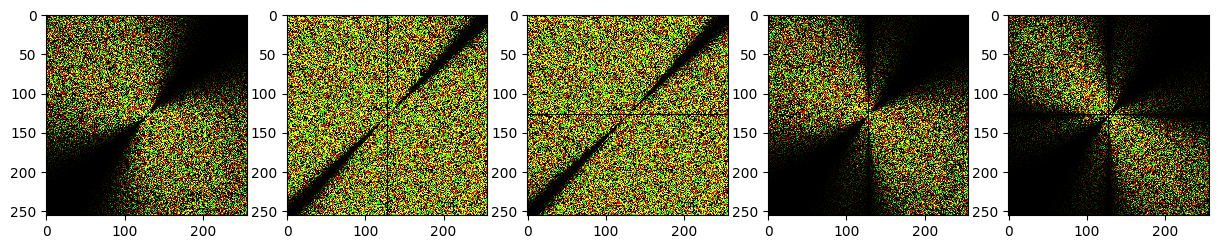

In [258]:
#spectrums
dummy = np.zeros((N, N, 4), dtype="f4")
dummy[:,:,3] = 1

plt.figure(figsize=(15, 3))
plt.subplot(151)
dummy[:,:,0:2] = h_k_t_ri
plt.imshow(dummy, interpolation='nearest')
plt.subplot(152)
dummy[:,:,0:2] = h_k_t_ri_sx
plt.imshow(dummy, interpolation='nearest')
plt.subplot(153)
dummy[:,:,0:2] = h_k_t_ri_sy
plt.imshow(dummy, interpolation='nearest')
plt.subplot(154)
dummy[:,:,0:2] = h_k_t_ri_dx
plt.imshow(dummy, interpolation='nearest')
plt.subplot(155)
dummy[:,:,0:2] = h_k_t_ri_dxy
plt.imshow(dummy, interpolation='nearest')
plt.show()

# IFFT

In [217]:
def rev_bit(log2N):
    N = np.power(2, log2N)
    arr = []
    for i in range(N):
        bin_str = bin(i)[2:]
        bin_str = '0'*(log2N-len(bin_str))+bin_str

        arr.append(int(bin_str[::-1], 2))
    return np.array(arr, dtype=int)

In [241]:
rev = rev_bit(log2N)
twid_arr = np.zeros((N, log2N, 4), dtype='f4')
for i in range(log2N):
    for n in range(N):
        top_wing = np.mod(n, np.power(2, i+1))<np.power(2, i)
        span = np.power(2, i)
        twi = np.exp(1j * 2 * np.pi * n / (2*span))
        if i == 0:
            if top_wing:
                twid_arr[n, i] = [twi.real, twi.imag, rev[n], rev[n+span]]
            else:
                twid_arr[n, i] = [twi.real, twi.imag, rev[n-span], rev[n]]
        else:
            if top_wing:
                twid_arr[n, i] = [twi.real, twi.imag, n, n+span]
            else:
                twid_arr[n, i] = [twi.real, twi.imag, n-span, n]
# plt.imshow(twid_arr,aspect=log2N/N, interpolation="nearest")
# plt.show()

In [259]:
def IFFT(N, spectrum):
    pingpong0 = np.zeros((N, 2), dtype='f4')
    pingpong1 = np.zeros((N, 2), dtype='f4')
    pingpong0=spectrum.copy().astype('f4')
    for stage in range(log2N):
        for n in range(N):
            twid_row = twid_arr[n, stage]
            w = twid_row[0]+1j*twid_row[1]

            idx1 = int(twid_row[2])
            idx2 = int(twid_row[3])

            g = pingpong0[idx1][0]+1j*pingpong0[idx1][1]
            h = pingpong0[idx2][0]+1j*pingpong0[idx2][1]

            res = g+w*h

            pingpong1[n] = [res.real, res.imag]
        
        if stage<log2N-1:
            pingpong0, pingpong1 = pingpong1, pingpong0
    return pingpong1/N

In [260]:
def IFFT_2D(spectrum):
    N = spectrum.shape[0]
    stage1 = np.zeros((N, N, 2), dtype='f4')
    res1 = np.zeros((N, N, 2), dtype='f4')

    for r in range(N):
        stage1[:, r] = IFFT(N, spectrum[:, r])

    for r in range(N):
        res1[r, :]= IFFT(N, stage1[r, :])
    return res1

In [261]:
inv_tex = np.zeros((N, N))
inv_tex = (np.mod(nx+ny, 2)-0.5)*2

In [264]:
Ht = IFFT_2D(h_k_t_ri)
Sxt = IFFT_2D(h_k_t_ri_sx)
Syt = IFFT_2D(h_k_t_ri_sy)
Dxt = IFFT_2D(h_k_t_ri_dx)
Dyt = IFFT_2D(h_k_t_ri_dy)
Dxyt = IFFT_2D(h_k_t_ri_dxy)

In [265]:
Ht = Ht[:,:,0]*inv_tex
Sxt = Sxt[:,:,0]*inv_tex
Syt = Syt[:,:,0]*inv_tex
Dxt = Dxt[:,:,0]*inv_tex
Dyt = Dyt[:,:,0]*inv_tex
Dxyt = Dxyt[:,:,0]*inv_tex

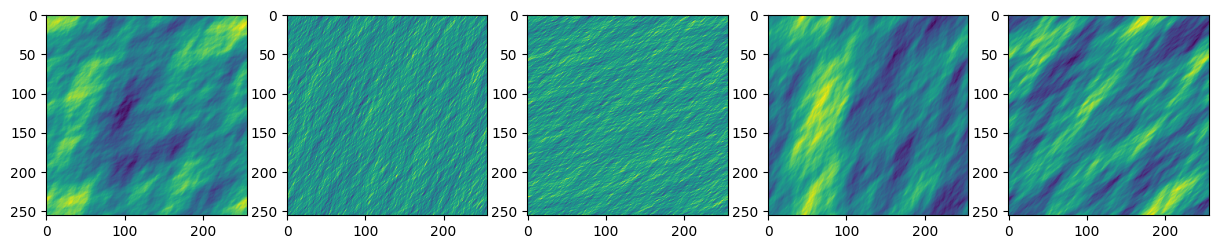

In [266]:
plt.figure(figsize=(15, 3))
plt.subplot(151)
plt.imshow(Ht)
plt.subplot(152)
plt.imshow(Sxt)
plt.subplot(153)
plt.imshow(Syt)
plt.subplot(154)
plt.imshow(Dxt)
plt.subplot(155)
plt.imshow(Dxyt)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


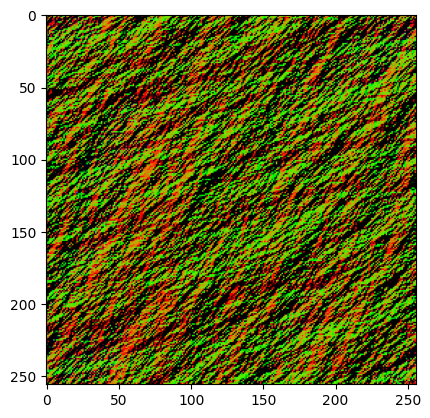

In [296]:
n = np.stack((-Sxt, -Syt, Ht), axis=2)
n = n/np.linalg.norm(n, axis=2).reshape((N, N, 1))
plt.imshow(n)
plt.show()

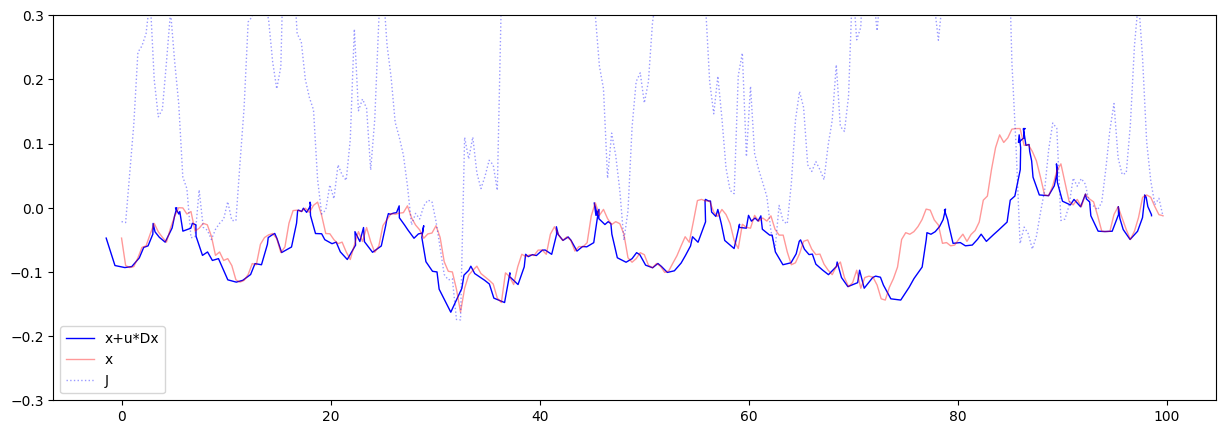

In [291]:
u = -20
ocean_surf = np.stack((X+u*Dxt, Y+u*Dyt, Ht), axis=2)
Jxx = 1+u*Dxt
Jxy = u*Dxyt
Jyx = u*Dxyt
Jyy = 1+u*Dyt

DetJ = Jxx*Jyy-Jxy*Jyx

plt.figure(figsize=(15, 5))
plt.plot(ocean_surf[:,int(N/2), 1], ocean_surf[:,int(N/2), 2], lw=1, color="b", label="x+u*Dx")
plt.plot(Y[:,int(N/2)], Ht[:,int(N/2)], lw=1, color="r", label="x", alpha=0.4)
plt.plot(Y[:,int(N/2)], DetJ[:,int(N/2)]/6, lw=1, color="b", linestyle=":", label="J", alpha=0.4)
plt.ylim(-.3, 0.3)
plt.legend()
plt.show()